# Imports
***

In [1]:
# Data sources can be obtained from the following links:
# "https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017"
# "https://www.kaggle.com/datasets/cashncarry/fifaworldranking"

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def loss_function(t1: tuple[int, int], t2: tuple[int, int]) -> int:
    """
    Compare two tuples of scores and return a score based on specific conditions.

    :param t1: A tuple containing two integers representing scores.
    :param t2: A tuple containing two integers representing scores.
    :return: An integer score based on the comparison.
    """
    if t1 == t2:
        return -3
    
    difference1 = t1[0] - t1[1]
    difference2 = t2[0] - t2[1]
    
    if difference1 == 0 and difference2 == 0:
        return -1
    if difference1 == difference2:
        return -2
    if (difference1 > 0 and difference2 > 0) or (difference1 < 0 and difference2 < 0):
        return -1
    return 0


def plot_comparable_matches(df: pd.DataFrame, team: str) -> None:
    plt.figure(figsize=(15, 5))
    bars = plt.bar(
        x=df["away_team"]+"\n"+df["date"].astype(str), 
        height=df["weight"]
    )
    for bar, annotation in zip(bars, df["score"]):
        yval = bar.get_height()
        plt.text(x=bar.get_x() + bar.get_width()/2, y=yval, s=annotation, ha="center", va="bottom")

    plt.title(f"Comparable Matches for {team}")
    plt.ylabel("Weight")
    plt.show()

# Processing
***

In [4]:
from processing import (
    clean_results, 
    clean_rankings, 
    duplicate_matches,
    merge_rankings, 
)

In [5]:
results_cols = ["date", "home_team", "away_team", "home_score", "away_score"]
results = pd.read_csv("data/results.csv", parse_dates=["date"], usecols=results_cols)
results = clean_results(results)
results.head()

,date,home_team,away_team,home_score,away_score
38335,2015-01-04,Bahrain,Jordan,1,0
38336,2015-01-04,Iran,Iraq,1,0
38337,2015-01-04,South Korea,Saudi Arabia,2,0
38338,2015-01-04,South Africa,Zambia,1,0
38339,2015-01-05,China PR,Oman,4,1


In [6]:
rankings_cols = ["rank_date", "country_full", "rank"]
rankings = pd.read_csv("data/rankings.csv", parse_dates=["rank_date"], usecols=rankings_cols)
rankings.rename(columns={
    "rank_date": "date", 
    "country_full": "country"
}, inplace=True)

country_map = {
    "USA": "United States", 
    "Korea Republic": "South Korea", 
    "Côte d'Ivoire": "Ivory Coast",
    "IR Iran": "Iran",
    "Czechia": "Czech Republic",
}
rankings["country"] = rankings["country"].replace(country_map)
rankings = clean_rankings(rankings)
rankings.head()

,country,date,rank
0,Guyana,1992-12-31,128
1,Barbados,1992-12-31,114
2,Chinese Taipei,1992-12-31,156
3,Mali,1992-12-31,69
4,Japan,1992-12-31,66


In [7]:
results = merge_rankings(results, rankings, "home_team")
results = merge_rankings(results, rankings, "away_team")

results.dropna(subset=["home_team_rank", "away_team_rank"], inplace=True)
results["home_team_rank"] = results["home_team_rank"].astype(int, errors="ignore")
results["away_team_rank"] = results["away_team_rank"].astype(int, errors="ignore")

df = duplicate_matches(results)
df["score"] = list(zip(df["home_score"], df["away_score"]))
df.head()

,date,home_team,away_team,home_score,away_score,home_team_rank,away_team_rank,rank_diff,score
0,2015-01-04,Bahrain,Jordan,1,0,122,81,41,"(1, 0)"
7498,2015-01-04,Jordan,Bahrain,0,1,81,122,-41,"(0, 1)"
7499,2015-01-04,Iraq,Iran,0,1,103,51,52,"(0, 1)"
7501,2015-01-04,Zambia,South Africa,0,1,46,52,-6,"(0, 1)"
7500,2015-01-04,Saudi Arabia,South Korea,0,2,102,69,33,"(0, 2)"


# Predict
***

In [8]:
from predict import (
    draw_result,
    get_comparable_matches, 
    get_offense_defense, 
    get_ranking, 
    predict_score,
)

In [9]:
day = datetime(2024, 6, 1)
home_team = "Austria"
away_team = "France"
params = {"time_sigma": 90, "rank_sigma": 15}

home_rank = get_ranking(df=rankings, team=home_team, day=day)
away_rank = get_ranking(df=rankings, team=away_team, day=day)
rank_diff = home_rank - away_rank

print(f"{home_team} rank: {home_rank}")
print(f"{away_team} rank: {away_rank}")

home_team_matches = get_comparable_matches(df=df, team=home_team, rank_diff=rank_diff, day=day, **params).head(10)
away_team_matches = get_comparable_matches(df=df, team=away_team, rank_diff=-rank_diff, day=day, **params).head(10)

Austria rank: 25
France rank: 2


In [10]:
predicted_score = predict_score(
    df=df, 
    rankings=rankings, 
    home_team=home_team, 
    away_team=away_team, 
    day=day
)
print(f"{home_team} - {away_team} {predicted_score[0]}:{predicted_score[1]}")

Austria - France 0:1


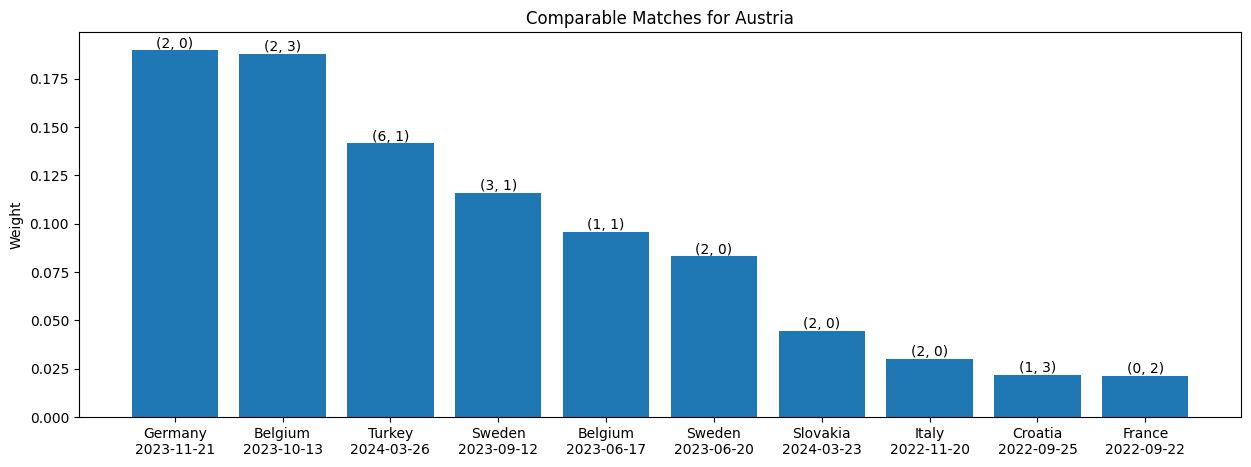

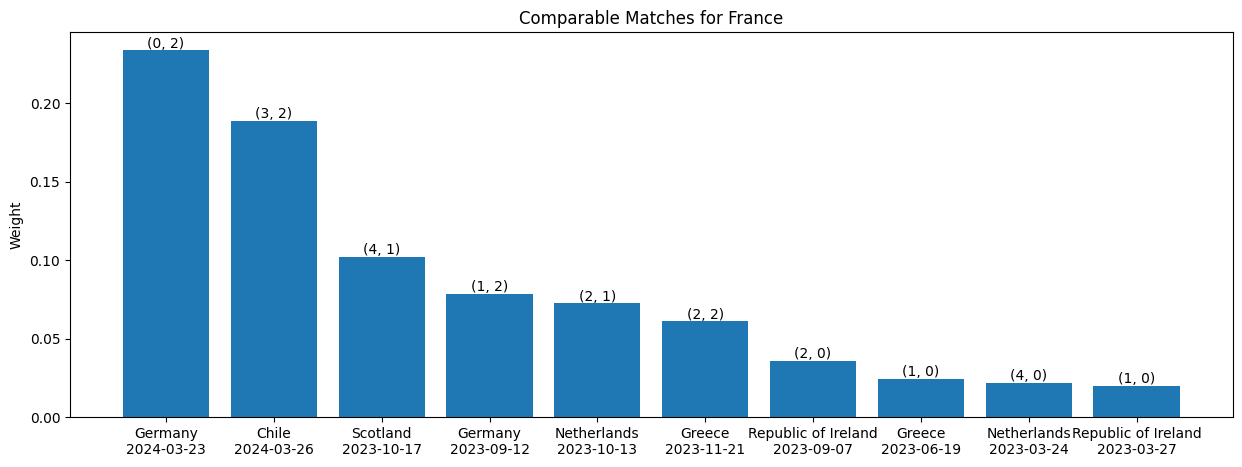

In [11]:
plot_comparable_matches(home_team_matches, home_team)
plot_comparable_matches(away_team_matches, away_team)

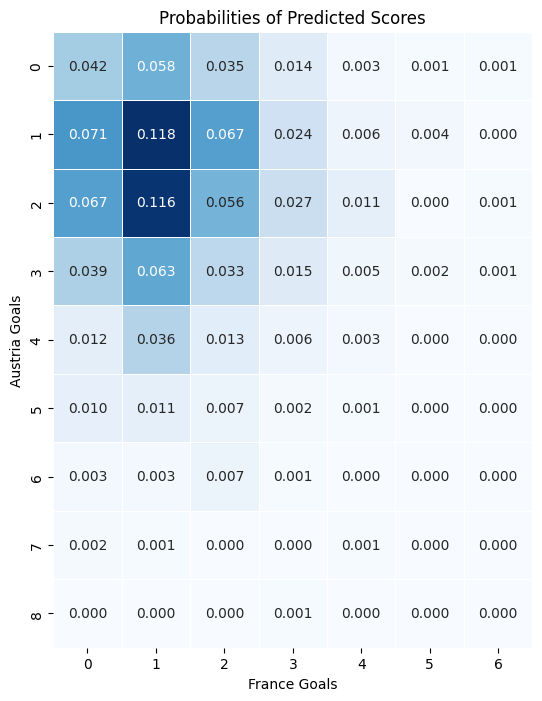

In [12]:
home_team_stats = get_offense_defense(home_team_matches)
away_team_stats = get_offense_defense(away_team_matches)
predicted_scores = draw_result(home_team_stats, away_team_stats, n=1000)

heatmap_df = pd.crosstab(
    predicted_scores[0], 
    predicted_scores[1], 
    rownames=[home_team+" Goals"], 
    colnames=[away_team+" Goals"]
)
heatmap_df = heatmap_df.div(heatmap_df.sum().sum())

plt.figure(figsize=(8, 8))
sns.heatmap(data=heatmap_df, annot=True, fmt=".3f", cmap="Blues", cbar=False, square=True, edgecolor="w", lw=0.5)
plt.title("Probabilities of Predicted Scores")
plt.show()

# Tournament
***

In [13]:
gameplan = [
    ("Germany", "Scotland"),
    ("Hungary", "Switzerland"),
    ("Spain", "Croatia"),
    ("Italy", "Albania"),
    ("Poland", "Netherlands"),
    ("Slovenia", "Denmark"),
    ("Serbia", "England"),
    ("Romania", "Ukraine"),
    ("Belgium", "Slovakia"),
    ("Austria", "France"),
    ("Turkey", "Georgia"),
    ("Portugal", "Czech Republic"),
    ("Croatia", "Albania"),
    ("Germany", "Hungary"),
    ("Scotland", "Switzerland"),
    ("Slovenia", "Serbia"),
    ("Denmark", "England"),
    ("Spain", "Italy"),
    ("Slovakia", "Ukraine"),
    ("Poland", "Austria"),
    ("Netherlands", "France"),
    ("Georgia", "Czech Republic"),
    ("Turkey", "Portugal"),
    ("Belgium", "Romania"),
    ("Scotland", "Hungary"),
    ("Switzerland", "Germany"),
    ("Albania", "Spain"),
    ("Croatia", "Italy"),
    ("France", "Poland"),
    ("Netherlands", "Austria"),
    ("Denmark", "Serbia"),
    ("England", "Slovenia"),
    ("Ukraine", "Belgium"),
    ("Slovakia", "Romania"),
    ("Czech Republic", "Turkey"),
    ("Georgia", "Portugal"),
]

In [14]:
all_scores = []

for h, a in gameplan:
    score = predict_score(
        df=df, 
        rankings=rankings, 
        home_team=h, 
        away_team=a, 
        day=day
    )
    all_scores.append((h,a, score))

pred_df = pd.DataFrame(all_scores, columns=["Home Team", "Away Team", "Score"])
pred_df.head(20)

,Home Team,Away Team,Score
0,Germany,Scotland,"(2, 1)"
1,Hungary,Switzerland,"(1, 1)"
2,Spain,Croatia,"(0, 2)"
3,Italy,Albania,"(2, 0)"
4,Poland,Netherlands,"(0, 1)"
5,Slovenia,Denmark,"(1, 1)"
6,Serbia,England,"(0, 0)"
7,Romania,Ukraine,"(0, 3)"
8,Belgium,Slovakia,"(0, 0)"
9,Austria,France,"(0, 2)"
